# 06.1v: Optimal Projection Sky Map

**Goal:** Visualize the sky using the optimal basis vectors found by 06.1u.

This notebook loads the precomputed optimal projection basis and creates a sky map showing the black holes in the orientation that maximizes their angular extent.

**Key difference from 06.1t:** Instead of computing PCs, we load the optimized basis vectors directly from `optimal_projection_basis.safetensors`.

## Parameters

In [1]:
TENSOR_DIR = "../data/tensors"
GAMMA_FILE = "gamma_qwen3_4b_instruct_2507.safetensors"
CENTROID_FILE = "gamma_centroid_mu.safetensors"
OPTIMAL_BASIS_FILE = "optimal_projection_basis.safetensors"
BH_DISTANCES_FILE = "black_hole_distances_qwen3_4b_instruct_2507.safetensors"

# Viewing direction: rotate plot so this longitude is centered
HEADING = 0

# Zoom interface: specify center and angular radius
# Set all to None to show full sky
CENTER_LON = 145.2  # Center on black holes
CENTER_LAT = 44.9   # Center on black holes (CDF-flattened position)
ANGULAR_RADIUS = 5  # degrees

# Zone boundaries (distances from black hole centroid)
BLACK_HOLE_R = 1e-4
CUCKOO_R = 1e-3
EXCLUSION_R = 1e-2

# Visualization
POINT_SIZE = 3
POINT_ALPHA = 1.0
FIGURE_DPI = 100

data_dir = Path(TENSOR_DIR)

print("Loading gamma matrix...")
gamma = load_file(data_dir / GAMMA_FILE)['gamma']
N, d = gamma.shape
print(f"Loaded: {gamma.shape}")

print("\nLoading cloud centroid...")
cloud_centroid = load_file(data_dir / CENTROID_FILE)['mu']
print(f"Cloud centroid norm: {torch.norm(cloud_centroid).item():.6f}")

print("\nLoading optimal basis vectors...")
optimal_basis_data = load_file(data_dir / OPTIMAL_BASIS_FILE)
north_vector = optimal_basis_data['north_vector']
meridian_vector = optimal_basis_data['meridian_vector']
equinox_vector = optimal_basis_data['equinox_vector']
angular_extent = optimal_basis_data['angular_extent'].item()
print(f"Optimal angular extent: {angular_extent:.2f} square degrees")

print("\nLoading black hole distances...")
bh_data = load_file(data_dir / BH_DISTANCES_FILE)
distances_from_bh = bh_data['distances']
print(f"Loaded distances for {len(distances_from_bh):,} tokens")

In [2]:
import torch
import numpy as np
from safetensors.torch import load_file
from pathlib import Path
import matplotlib.pyplot as plt

print("Imports loaded successfully.")

Imports loaded successfully.


## Step 1: Load Data

In [3]:
data_dir = Path(TENSOR_DIR)

print("Loading gamma matrix...")
gamma = load_file(data_dir / GAMMA_FILE)['gamma']
N, d = gamma.shape
print(f"Loaded: {gamma.shape}")

print("\nLoading cloud centroid...")
cloud_centroid = load_file(data_dir / CENTROID_FILE)['mu']
print(f"Cloud centroid norm: {torch.norm(cloud_centroid).item():.6f}")

print("\nLoading optimal basis vectors...")
optimal_basis_data = load_file(data_dir / OPTIMAL_BASIS_FILE)
north_vector = optimal_basis_data['north_vector']
meridian_vector = optimal_basis_data['meridian_vector']
equinox_vector = optimal_basis_data['equinox_vector']
angular_extent = optimal_basis_data['angular_extent'].item()
print(f"Optimal angular extent: {angular_extent:.2f} square degrees")

print("\nLoading black hole distances...")
bh_data = load_file(data_dir / BH_DISTANCES_FILE)
distances_from_bh = bh_data['distances']
print(f"Loaded distances for {len(distances_from_bh):,} tokens")

Loading gamma matrix...
Loaded: torch.Size([151936, 2560])

Loading cloud centroid...
Cloud centroid norm: 0.304777

Loading optimal basis vectors...
Optimal angular extent: 0.60 square degrees

Loading black hole distances...
Loaded distances for 151,936 tokens


## Step 2: Classify Tokens by Zone

In [4]:
black_hole_mask = distances_from_bh <= BLACK_HOLE_R
cuckoo_mask = (distances_from_bh > BLACK_HOLE_R) & (distances_from_bh <= CUCKOO_R)
exclusion_mask = (distances_from_bh > CUCKOO_R) & (distances_from_bh <= EXCLUSION_R)
bulk_mask = distances_from_bh > EXCLUSION_R

n_black_holes = black_hole_mask.sum().item()
n_cuckoos = cuckoo_mask.sum().item()
n_exclusion = exclusion_mask.sum().item()
n_bulk = bulk_mask.sum().item()

print(f"Zone populations:")
print(f"  Black holes: {n_black_holes:,}")
print(f"  Cuckoos: {n_cuckoos:,}")
print(f"  Exclusion zone: {n_exclusion:,}")
print(f"  Bulk: {n_bulk:,}")

Zone populations:
  Black holes: 2,183
  Cuckoos: 27
  Exclusion zone: 11
  Bulk: 149,715


## Step 3: Convert to Spherical Coordinates Using Optimal Basis

In [5]:
print("\nCentering at cloud centroid...")
gamma_prime = gamma - cloud_centroid

print("Projecting onto optimal basis vectors...")
x = gamma_prime @ meridian_vector
y = gamma_prime @ equinox_vector
z = gamma_prime @ north_vector

print("Converting to spherical coordinates...")
r = torch.sqrt(x**2 + y**2 + z**2)
theta_rad = torch.asin(torch.clamp(z / r, -1, 1))
theta_deg = torch.rad2deg(theta_rad)
phi_rad = torch.atan2(y, x)
phi_deg = torch.rad2deg(phi_rad)

print(f"\nLatitude statistics (before CDF flattening):")
print(f"  Mean: {theta_deg.mean().item():.6f}°")
print(f"  Std: {theta_deg.std().item():.6f}°")
print(f"  Min: {theta_deg.min().item():.6f}°")
print(f"  Max: {theta_deg.max().item():.6f}°")


Centering at cloud centroid...
Projecting onto optimal basis vectors...
Converting to spherical coordinates...

Latitude statistics (before CDF flattening):
  Mean: 0.756669°
  Std: 38.970177°
  Min: -89.664284°
  Max: 89.799232°


## Step 4: Apply CDF Flattening to Latitude

In [6]:
print("\nApplying CDF flattening...")
theta_sorted, sort_indices = torch.sort(theta_deg)
cdf_values = torch.linspace(0, 1, N)
theta_flat_sorted = 90.0 * (2.0 * cdf_values - 1.0)
theta_flat = torch.zeros_like(theta_deg)
theta_flat[sort_indices] = theta_flat_sorted

print(f"Flattened latitude statistics:")
print(f"  Mean: {theta_flat.mean().item():.6f}°")
print(f"  Std: {theta_flat.std().item():.6f}°")


Applying CDF flattening...
Flattened latitude statistics:
  Mean: 0.000000°
  Std: 51.962036°


## Step 5: Apply Heading Rotation

In [7]:
phi_rotated = phi_deg - HEADING
phi_rotated = torch.where(phi_rotated > 180, phi_rotated - 360, phi_rotated)
phi_rotated = torch.where(phi_rotated < -180, phi_rotated + 360, phi_rotated)

print(f"Applied heading rotation: {HEADING}°")

Applied heading rotation: 0°


## Step 6: Determine Plot Limits

In [8]:
if CENTER_LON is not None and CENTER_LAT is not None and ANGULAR_RADIUS is not None:
    lon_min = CENTER_LON - ANGULAR_RADIUS
    lon_max = CENTER_LON + ANGULAR_RADIUS
    lat_min = CENTER_LAT - ANGULAR_RADIUS
    lat_max = CENTER_LAT + ANGULAR_RADIUS
    zoom_mode = f"centered at ({CENTER_LON}°, {CENTER_LAT}°), radius {ANGULAR_RADIUS}°"
else:
    lon_min = -180
    lon_max = 180
    lat_min = -90
    lat_max = 90
    zoom_mode = "full sky"

print(f"\nZoom mode: {zoom_mode}")
print(f"  Longitude: [{lon_min}°, {lon_max}°]")
print(f"  Latitude: [{lat_min}°, {lat_max}°]")


Zoom mode: centered at (145.2°, 44.9°), radius 5°
  Longitude: [140.2°, 150.2°]
  Latitude: [39.9°, 49.9°]


## Step 7: Report Black Hole Locations

In [9]:
bh_lons = phi_rotated[black_hole_mask].cpu().numpy()
bh_lats = theta_flat[black_hole_mask].cpu().numpy()

print(f"\nBlack hole locations in optimal projection:")
print(f"  Longitude range: [{bh_lons.min():.2f}°, {bh_lons.max():.2f}°]")
print(f"  Latitude range: [{bh_lats.min():.2f}°, {bh_lats.max():.2f}°]")
print(f"  Longitude span: {bh_lons.max() - bh_lons.min():.2f}°")
print(f"  Latitude span: {bh_lats.max() - bh_lats.min():.2f}°")
print(f"  Mean position: ({bh_lons.mean():.2f}°, {bh_lats.mean():.2f}°)")


Black hole locations in optimal projection:
  Longitude range: [144.80°, 145.62°]
  Latitude range: [43.06°, 46.67°]
  Longitude span: 0.83°
  Latitude span: 3.60°
  Mean position: (145.39°, 44.91°)


## Step 8: Create Sky Map


Creating sky map...


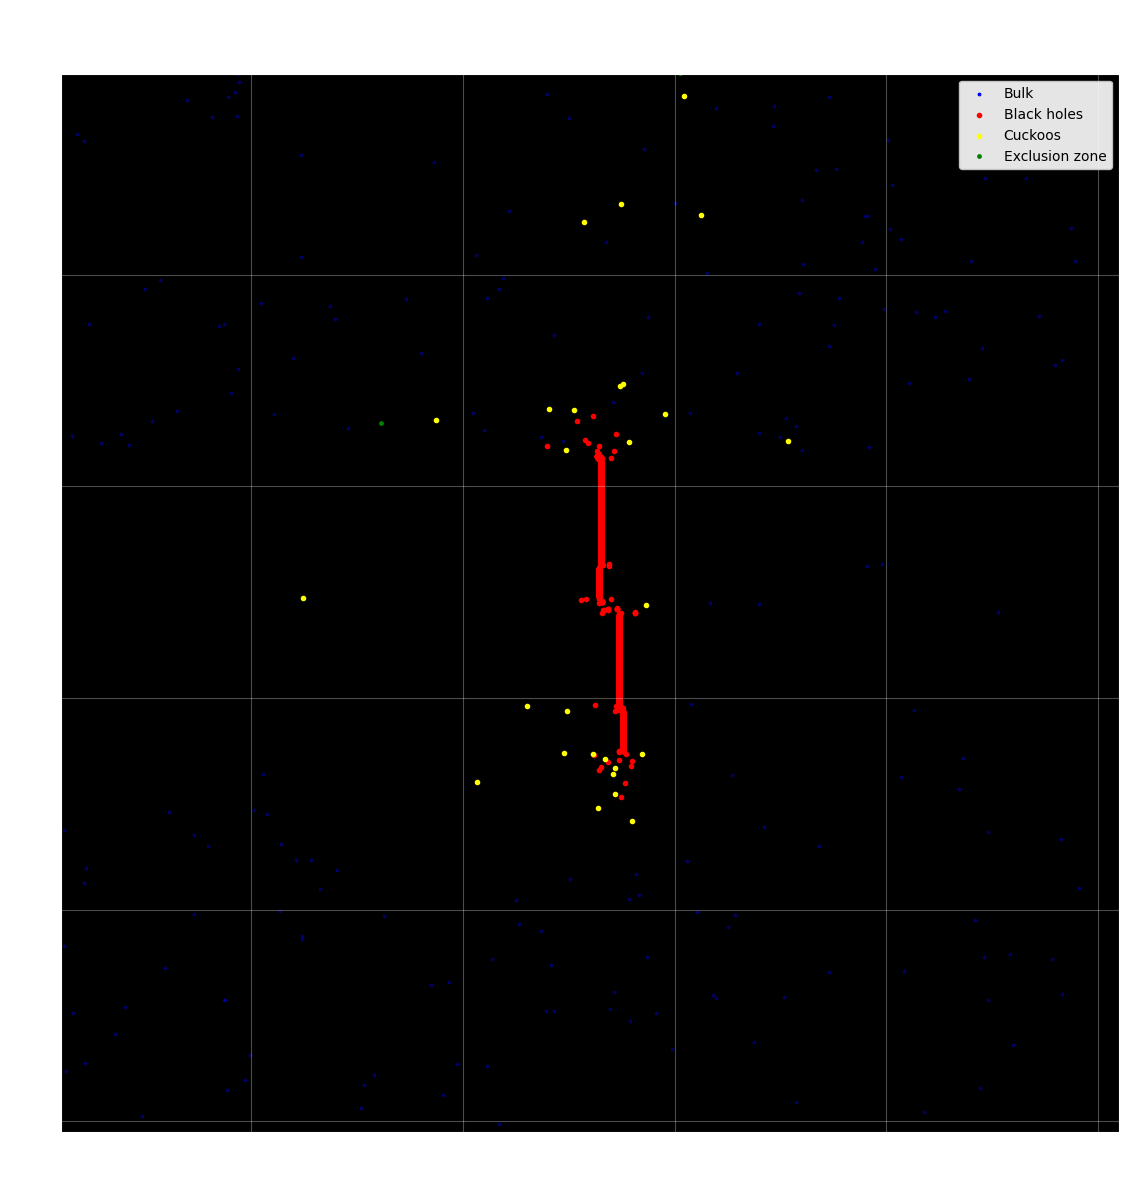


Sky map complete!
  Red: 2,183 black holes
  Yellow: 27 cuckoos
  Green: 11 exclusion zone tokens
  Blue: 149,715 bulk tokens


In [10]:
print("\nCreating sky map...")

# Convert to numpy
phi_np = phi_rotated.cpu().numpy()
theta_flat_np = theta_flat.cpu().numpy()
black_hole_np = black_hole_mask.cpu().numpy()
cuckoo_np = cuckoo_mask.cpu().numpy()
exclusion_np = exclusion_mask.cpu().numpy()
bulk_np = bulk_mask.cpu().numpy()

# Create figure
fig, ax = plt.subplots(figsize=(12, 12), dpi=FIGURE_DPI)
ax.set_facecolor('black')

# Plot in layers: bulk (background), black holes, cuckoos, exclusion (foreground)
ax.scatter(phi_np[bulk_np], theta_flat_np[bulk_np],
           s=POINT_SIZE, alpha=POINT_ALPHA*0.3, c='blue', label='Bulk', rasterized=True)

ax.scatter(phi_np[black_hole_np], theta_flat_np[black_hole_np],
           s=POINT_SIZE*3, alpha=POINT_ALPHA, c='red', label='Black holes', rasterized=True)

ax.scatter(phi_np[cuckoo_np], theta_flat_np[cuckoo_np],
           s=POINT_SIZE*3, alpha=POINT_ALPHA, c='yellow', label='Cuckoos', rasterized=True)

ax.scatter(phi_np[exclusion_np], theta_flat_np[exclusion_np],
           s=POINT_SIZE*2, alpha=POINT_ALPHA, c='green', label='Exclusion zone', rasterized=True)

# Set limits and grid
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3, color='white')

# Labels
ax.set_xlabel('Longitude (degrees)', color='white', fontsize=12)
ax.set_ylabel('Latitude (CDF-flattened, degrees)', color='white', fontsize=12)
ax.set_title(f'Sky Map in Optimal Projection\nAngular Extent: {angular_extent:.2f} sq deg | {zoom_mode}',
             color='white', pad=20, fontsize=14)

# White axes and ticks
ax.tick_params(colors='white')
for spine in ax.spines.values():
    spine.set_edgecolor('white')

# Legend
legend = ax.legend(loc='upper right', framealpha=0.9, fontsize=10)
for handle in legend.legend_handles:
    handle.set_alpha(1.0)

plt.tight_layout()
plt.show()

print(f"\nSky map complete!")
print(f"  Red: {n_black_holes:,} black holes")
print(f"  Yellow: {n_cuckoos:,} cuckoos")
print(f"  Green: {n_exclusion:,} exclusion zone tokens")
print(f"  Blue: {n_bulk:,} bulk tokens")

## Summary

We visualized the sky using the optimal projection basis found by algorithmically searching 1000 random orthonormal bases in 06.1u.

**This is the face-on view** — the projection that maximizes the black holes' angular extent across the sky.

If the black holes still appear as a stripe rather than a blob, it means the 3D pancake structure is **extremely flat** — possibly closer to a 2D manifold than a true 3D volume.